<a href="https://colab.research.google.com/github/neal-logan/dsba6211-summer2024/blob/main/nophishing/02_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No Phishing: Detecting Malicious URLs
## Notebook 02: Models and Evaluation

### Environment Setup

##### Install required packages

In [1]:
#Docs: https://github.com/facebookresearch/hiplot
%%capture
!pip install hiplot==0.1.33

In [1]:
#Docs: https://github.com/SelfExplainML/PiML-Toolbox
%%capture
!pip install PiML==0.6.0

##### Set random seed

In [2]:
random_seed = 42

## Training Data Preparation

### Overview of the Dataset

First, a quick review of the data explored in the previous notebook.  The dataset consistes of the raw URL, the binary phishing label, and 87 features, including:
* 56 from URL syntax and structure,
* 24 from corresponding site content, and
* 7 from external services.

### Preprocessing Steps

Prior to beginning the preprocessing pipeline, the following transformations are made:
* Transform the target variable **status** to binary, where 1 = 'phishing' and 0 = 'legitimate', and rename the column to **y**
* Drop the raw URL, as the modeling techniques can only make effective use of quantitative features.
* Drop all columns identified as unnecessary during exploratory data analysis
* Split the **training** dataset into X and y divisions (separating the features from the target variable), and each of these into training and validation data frames (the original dataset did not contain a separate validation set).  

Note: The **test** dataset will not be loaded until final model evaluation.

### Selected Features

Based on analysis conducted in [01 Exploratory Analysis](https://github.com/neal-logan/dsba6211-summer2024/blob/b3308e42ffb44ffdf364b85520f4af9c19ece147/nophishing/01_exploratory_analysis.ipynb), 14 features were selected. Roughly in order of importance, these selected features included:
* google_index
* page_rank
* nb_www
* nb_hyperlinks
* domain_age
* phish_hints
* nb_hyphens
* nb_qm
* web_traffic
* ratio_digits_host
* nb_dots
* length_words_raw
* nb_slash
* ratio_extHyperlinks

### Contextual Notes on Feature Selection

The importance of these features drops off very quickly, with the most important feature (google_index) around 50 times more important than the least-important feature. The importance threshold was set as low as it was because accuracy tends to need to be emphasized in this context, and also can be, for a few reasons.

The difference between 96.0% precision or recall and, say, 96.4% may not seem like much, but at the margin it's a 10% reduction in prevented attacks or false positives.  The inconvenience of a message incorrectly blocked can be substantial, and the damage caused by a succesful attack can be catastrophic.  Social engineering schemes like phishing are among the most dangerous and difficult threats to address, and in many cases will not be detected even security experts.

At the same time, models used to detect fraud attempts or raise other pressing security concerns in a high-velocity, high-volume context like messaging should be (and typically will be) monitored closely and updated regularly as threat actors' tactics change.  If a model like this becomes slightly outdated due to changes in TA tactics, the problem can be rectified promptly--as long as labels are promptly obtained, in this case mainly from messaging users.

In [3]:
# Load training dataset (this will be divided into train and validation sets)
import pandas as pd

train_url = 'https://raw.githubusercontent.com/neal-logan/dsba6211-summer2024/main/nophishing/data/phishing-url-pirochet-train.csv'
df = pd.read_csv(train_url)

In [4]:
# 14 Features selected through exploratory data analysis

selected_features = [
    'google_index', 'page_rank', 'nb_www', 'nb_hyperlinks', 'domain_age',
    'phish_hints', 'nb_hyphens', 'nb_qm', 'web_traffic', 'ratio_digits_host',
    'nb_dots', 'length_words_raw', 'nb_slash', 'ratio_extHyperlinks']


In [5]:
#Create numeric target variable column
df['y'] = df['status'].replace('legitimate', 0).replace('phishing', 1)

#Drop unnecessary columns, retaining only selected features and the target var
df = df.filter(selected_features + ['y'])

#Convert invalid values to show they are missing
import numpy as np
df['domain_age'] = [np.NaN if x < 0 else x for x in df['domain_age']]

In [6]:
#Feature/target split
X = df.drop(columns=['y'])
y = df['y']

In [7]:
#Training/validation split (test data not yet loaded)

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = random_seed)

## Model Development

### Modeling Methodology

An approach using sklearn's histogram-based gradient-boosted decision tree classifier was selected for the following reasons:
* **Accuracy**: GBTs tend to be very accurate; more accurate than random forest, and sometimes a great deal more accurate than logistic regression, although the differences were not overwhelming for this problem
* **Robustness**: HGBTs can handle outliers and missing data gracefully
* **Flexbility**: HGBTs can capture non-linear relationships, and sklearn's HGBT [handles categorical variables natively](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html), without special encoding
* **Explainability**: GBTs are reasonably transparent and explainable
* **Scalability**: HGBTs can dramatically outperform non-histogram GBTs in training speed due to bucketing, especially at scale

### Model Risk

Key model risk concerns include:
* Overfitting and underfitting
* Exploitable weakspots, and
* A lack of resilience to shifts in the distributions of legitimate activity or threat actor tactics.

### New Baseline Model


* **Histogram gradient-booosted tree model: ROC-AUC > 0.96**
 * Iterations limted to 100 (default 100, increased from 60)
 * Tree depth limited to 8 (default none, increased from 7)
 * Both parameters selected to simplify model and avoid overfitting, but increased slightly from EDA model to address undertraining
 * StandardScaler() removed as unnecessary for histogram-based GBT
 * Overfitting concerns minimal

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import pandas as pd

# Define model evaluation function

def print_model_evaluation(
    title: str,
    pipe : Pipeline,
    X : pd.DataFrame,
    y : pd.DataFrame):

    print("\n" + title)
    pred_y = pipe.predict(X)
    print(confusion_matrix(pred_y, y))
    print("\nROC-AUC: " + str(roc_auc_score(pred_y, y)))
    print("Precision: " + str(precision_score(pred_y, y)))
    print("Recall: " + str(recall_score(pred_y, y)))


In [21]:
# Set up and run pipeline - gradient boosted trees

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline

pipe_gbt = make_pipeline(
      HistGradientBoostingClassifier(
          max_iter=100,
          max_depth= 8,
          random_state=random_seed)
)

pipe_gbt.fit(X_train, y_train)

Pipeline(steps=[('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(max_depth=8, random_state=42))])

In [22]:
print_model_evaluation("Gradient-boosted Trees\nPerformance on Training Set",
                       pipe_gbt, X_train, y_train)

print_model_evaluation("Gradient-boosted Trees\nPerformance on Validation Set",
                       pipe_gbt, X_validation, y_validation)


Gradient-boosted Trees
Performance on Training Set
[[3051   27]
 [  25 3023]]

ROC-AUC: 0.9915129852189528
Precision: 0.9911475409836066
Recall: 0.9917979002624672

Gradient-boosted Trees
Performance on Validation Set
[[727  29]
 [ 26 750]]

ROC-AUC: 0.9640675285005182
Precision: 0.962772785622593
Recall: 0.9664948453608248


### PiML Experment Setup

The experiment was set up using the combined training and validation sets.  The performance metrics are suspicious, with accuracy at 0.96 yet AUC and F1 both greater than 0.99 on the 'test' (experiment-internal validation) set.


In [11]:
from piml import Experiment

In [102]:
exp = Experiment(highcode_only=True)

In [103]:
exp.data_loader(data = df)

,google_index,page_rank,nb_www,nb_hyperlinks,domain_age,phish_hints,nb_hyphens,nb_qm,web_traffic,ratio_digits_host,nb_dots,length_words_raw,nb_slash,ratio_extHyperlinks,y
0,1,4,1,502,8892.0,0,7,0,67860,0.0,2,10,4,0.081673,0
1,1,2,0,12,2996.0,0,0,0,4189860,0.0,2,6,7,0.083333,1
2,1,3,0,83,2527.0,1,0,0,346022,0.0,3,18,17,0.385542,1
3,0,4,1,91,7531.0,0,0,0,1059151,0.0,2,2,2,0.120879,0
4,1,5,0,38,7590.0,0,1,0,635,0.0,3,12,5,0.157895,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653,1,6,1,21,2344.0,1,2,1,13667,0.0,3,8,4,0.000000,1
7654,0,6,0,9,6588.0,0,0,0,140438,0.0,2,2,3,0.000000,0
7655,1,0,0,22,5014.0,2,2,0,0,0.0,2,9,7,0.318182,1
7656,0,6,1,86,8045.0,0,0,0,2580,0.0,3,6,5,0.093023,0


In [104]:
exp.data_prepare(target = 'y', task_type = 'classification', silent=True)

##### Train basic histogram GBT model

In [105]:
exp.model_train(
    model = HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=8,
        random_state=random_seed),
    name = 'hgbt')


In [106]:
exp.model_diagnose(model = 'hgbt', show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.9918,0.9997,0.9918,0.0366,0.0078
Test,0.9628,0.9924,0.9626,0.1051,0.0283
Gap,-0.0290,-0.0074,-0.0293,0.0686,0.0205


### Partial Dependency Plots & Monotonicity Assessment

Some features are already monotonously well-behaved, for example:
* phish_hints
* nb_hyphens
* nb_dots

Others show more complex and concerning patterns:
* web_traffic: high at extremely low or high traffic, and noisy in the middle.
* ratio_extHyperlinks: looks like a tilted 'W'

A few features are nearly monotonous, with some anomalies, suggesting that a monotonous constraint might be appropriate:
* page_rank: this feature seems like it pretty clearly should be monotonous
* nb_hyperlinks:
* ratio_digits_host:
* length_words_raw
* nb_slash


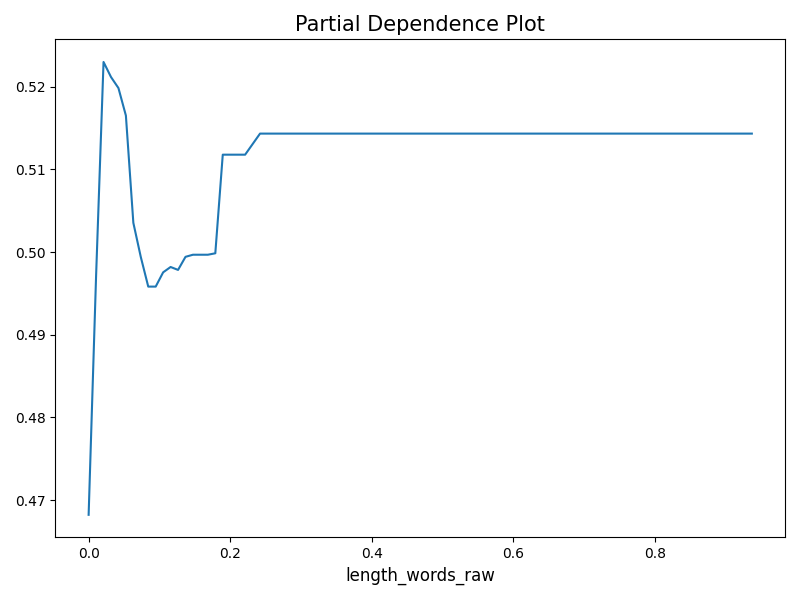

In [71]:
exp.model_explain(
    model='hgbt',
    show='pdp',
    uni_feature='length_words_raw')

### Train Model with Monotonicity Constraint

Given the results of the monotonicity assessment, a new model was developed with a monotonicity constraint on the five features which appeared to have a monotonous relationship, but which showed anomaloies:
* page_rank
* nb_hyperlinks
* ratio_digits_host
* length_words_raw
* nb_slash


In [157]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html
# This array controls the direction of monotonicity constraints by feature
# HistGradientBoostingClassifier's monotonic_cst parameter takes either (1) an
# array of the same length as the feature set, like this, or (2) a dictionary
# of specific features and the monotonicity setting for that feature, but (2)
# didn't work in this instance because for some reason, the feature names
# didn't pass through to the model. So this less-readable code was unavoidable.
# 1 = increasing constraint, -1 = decreasing constraint, 0 = no constraint
monotonic_contraints = [
    0,-1,0,-1,0,0,0,0,0,1,0,1,1,0
]

In [109]:
#Train model with the same settings as the new baseline HGBT
exp.model_train(
    model = HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=8,
        monotonic_cst = monotonic_contraints,
        random_state=random_seed),
    name = 'hgbt_mono')


### Accuracy & Monotonicity Comparison

Monotonicity constraints were applied while training the new model. Somewhat surprisingly, there was no loss of accuracy on the constrained model--in fact, accuracy improved very slightly on the 'test' (locally-partitioned validation) dataset.

Since these models both seem promising, we'll proceed to deeper analysis of them.

In [99]:
exp.model_diagnose(model = 'hgbt', show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.9918,0.9997,0.9918,0.0366,0.0078
Test,0.9628,0.9924,0.9626,0.1051,0.0283
Gap,-0.0290,-0.0074,-0.0293,0.0686,0.0205


In [100]:
exp.model_diagnose(model = 'hgbt_mono', show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.9825,0.9987,0.9826,0.0554,0.0137
Test,0.9634,0.9912,0.9634,0.1103,0.0291
Gap,-0.0191,-0.0075,-0.0192,0.0549,0.0154


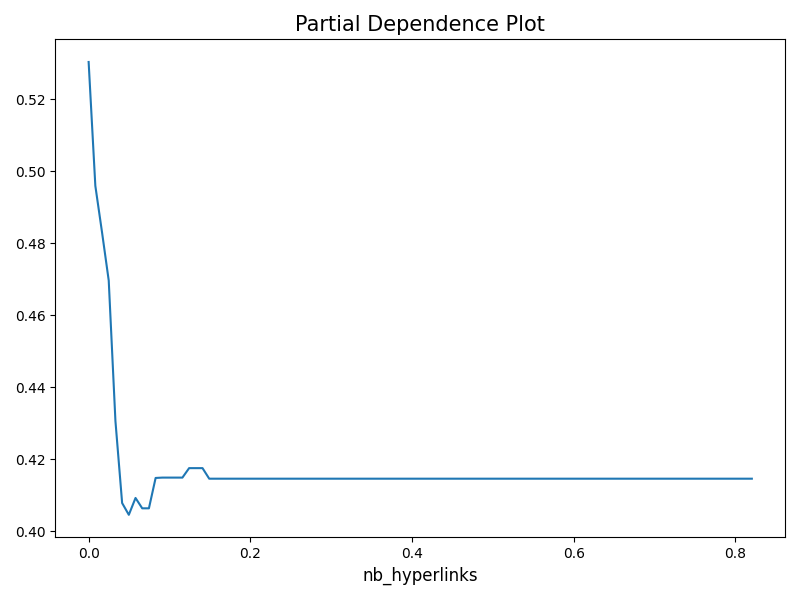

In [132]:
exp.model_explain(
    model='hgbt',
    show='pdp',
    uni_feature='nb_hyperlinks')

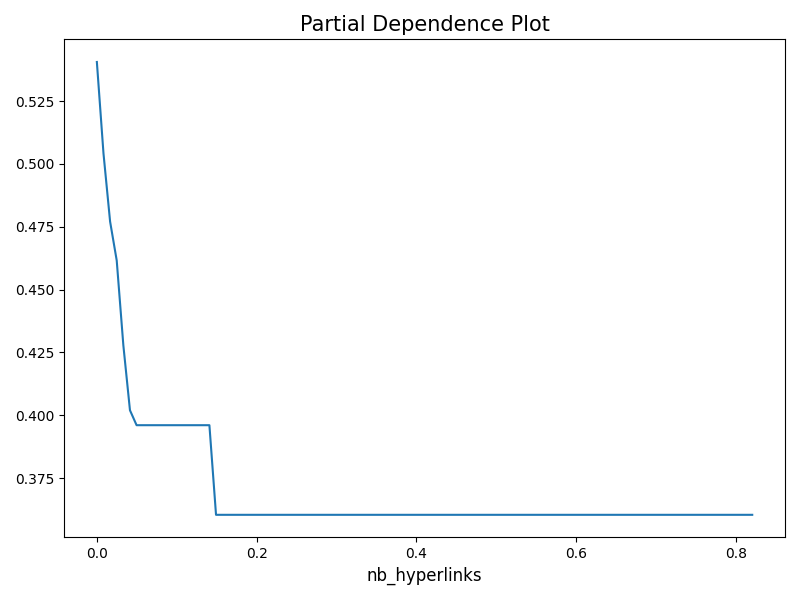

In [133]:
exp.model_explain(
    model='hgbt_mono',
    show='pdp',
    uni_feature='nb_hyperlinks')

### Overfitting Analysis

In the base hgbt model, some mild local overfitting was present in **page_rank** and **nb_slash**, based on individual feature assessments. Mild overfitting on **page_rank** is not surprising, given the non-monotonicity in unconstrained model, and this overfitting is adequately addressed in the monotonically-constrained model. Overfitting on **nb_slash**, however, has not been addressed.



google_index
No overfit regions detected.

page_rank


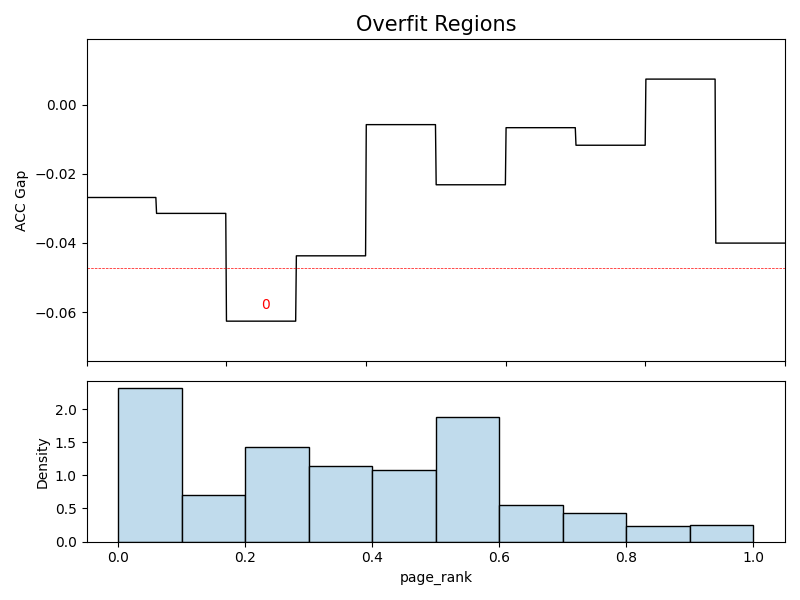


nb_www
No overfit regions detected.

nb_hyperlinks
No overfit regions detected.

phish_hints
No overfit regions detected.

nb_hyphens
No overfit regions detected.

nb_qm
No overfit regions detected.

web_traffic
No overfit regions detected.

ratio_digits_host
No overfit regions detected.

nb_dots
No overfit regions detected.

length_words_raw
No overfit regions detected.

nb_slash


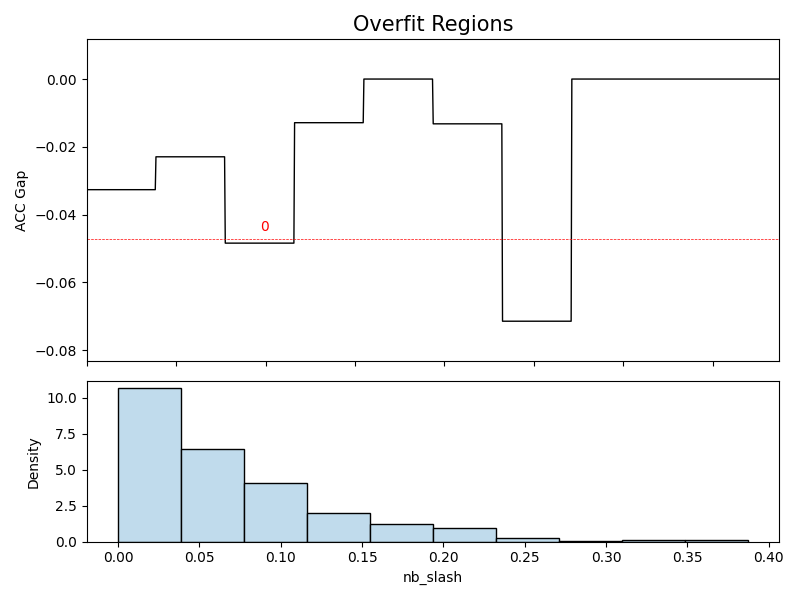


ratio_extHyperlinks
No overfit regions detected.


In [150]:
for col in df.columns:
  if col not in ['domain_age', 'y']:
    print('\n' + col)
    results = exp.model_diagnose(
        model="hgbt",
        show="overfit",
        slice_method="histogram",
        slice_features=[col],
        threshold=1.05,
        min_samples=100)



google_index
No overfit regions detected.

page_rank
No overfit regions detected.

nb_www
No overfit regions detected.

nb_hyperlinks
No overfit regions detected.

phish_hints
No overfit regions detected.

nb_hyphens
No overfit regions detected.

nb_qm
No overfit regions detected.

web_traffic
No overfit regions detected.

ratio_digits_host
No overfit regions detected.

nb_dots
No overfit regions detected.

length_words_raw
No overfit regions detected.

nb_slash


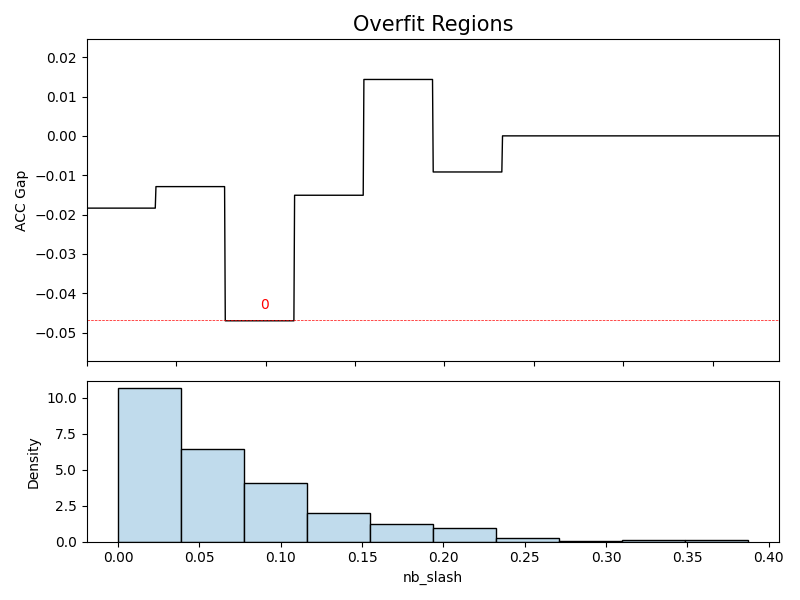


ratio_extHyperlinks
No overfit regions detected.


In [151]:
for col in df.columns:
  if col not in ['domain_age', 'y']:
    print('\n' + col)
    results = exp.model_diagnose(
    model="hgbt_mono",
    show="overfit",
    slice_method="histogram",
    slice_features=[col],
    threshold=1.05,
    min_samples=100)

### Weakspot Analysis

All features except domain_age were assessed individually for weak points. The missing values in domain_age seemed to cause problems with the test. Of the individually-tested features, only **ratio_digits_host** showed a weak point, and it was in an area of fairly low density.  

Interestingly, this weak point shows up only in the monotonicity-constrainted model.

In [129]:
for col in df.columns:
  if col not in ['domain_age', 'y']:
    print('\n' + col)
    exp.model_diagnose(
      model='hgbt',
      show='weakspot',
      slice_method='histogram',
      slice_features= [col],
      threshold=1.1,
      min_samples=200,
      metric='AUC',
      use_test=True)


google_index
No weak regions detected.

page_rank
No weak regions detected.

nb_www
No weak regions detected.

nb_hyperlinks
No weak regions detected.

phish_hints
No weak regions detected.

nb_hyphens
No weak regions detected.

nb_qm
No weak regions detected.

web_traffic
No weak regions detected.

ratio_digits_host
No weak regions detected.

nb_dots
No weak regions detected.

length_words_raw
No weak regions detected.

nb_slash
No weak regions detected.

ratio_extHyperlinks
No weak regions detected.



google_index
No weak regions detected.

page_rank
No weak regions detected.

nb_www
No weak regions detected.

nb_hyperlinks
No weak regions detected.

phish_hints
No weak regions detected.

nb_hyphens
No weak regions detected.

nb_qm
No weak regions detected.

web_traffic
No weak regions detected.

ratio_digits_host


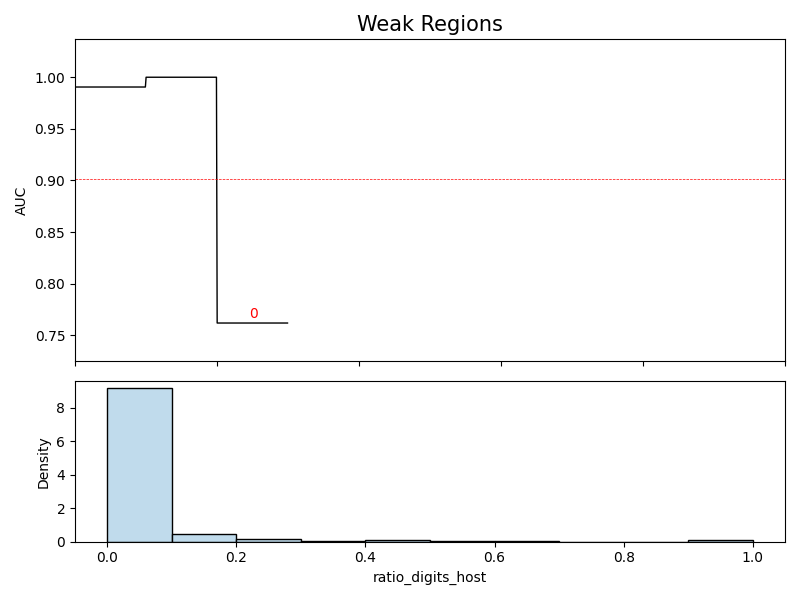


nb_dots
No weak regions detected.

length_words_raw
No weak regions detected.

nb_slash
No weak regions detected.

ratio_extHyperlinks
No weak regions detected.


In [128]:
for col in df.columns:
  if col not in ['domain_age', 'y']:
    print('\n' + col)
    exp.model_diagnose(
      model='hgbt_mono',
      show='weakspot',
      slice_method='histogram',
      slice_features= [col],
      threshold=1.1,
      min_samples=200,
      metric='AUC',
      use_test=True)

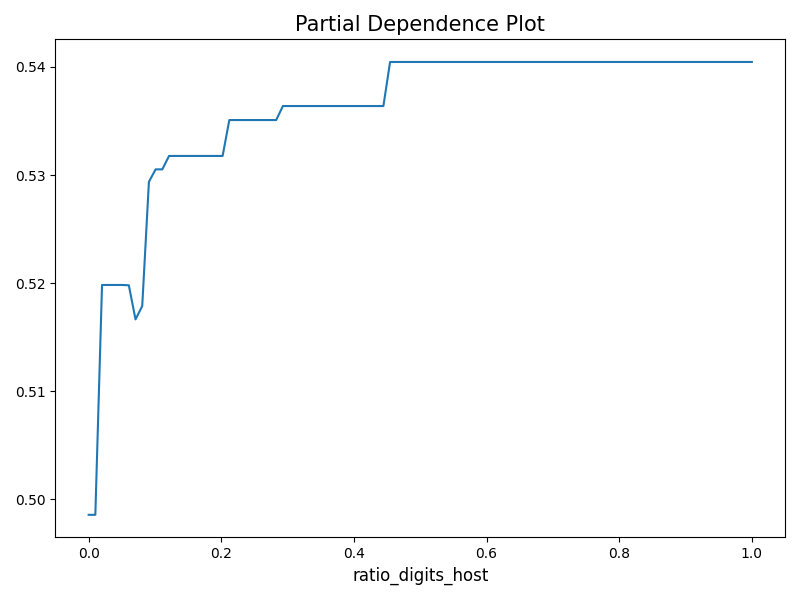

In [135]:
exp.model_explain(
    model='hgbt',
    show='pdp',
    uni_feature='ratio_digits_host')

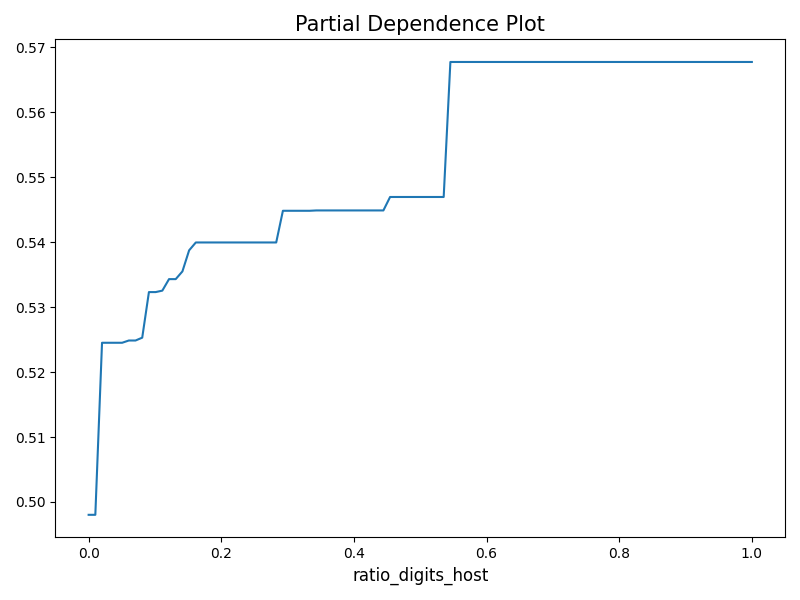

In [134]:
exp.model_explain(
    model='hgbt_mono',
    show='pdp',
    uni_feature='ratio_digits_host')

### Resilience Analysis

Although we might choose a more accurate model over a more resilient model to some extent in a closely-monitored context, *low* resilience is nevertheless intolerable.

Overall, we should expect this model to detect a lot of phishing even in scenarios with a large, sudden shift in legitimate activity or threat actor tactics: accuracy is still over 80% with a worst-case sample ratio of 0.2. Dropping from 96% accuracy to 80% represents a five-fold error, which we can expect to be apparent to both legitimate users and threat actors. A new model would be needed--urgently--but brief, occasional periods of weaker performance like this are typically tolerable.

Resilience distance analysis shows that **nb_hyperlinks**, **page_rank**, and other important features would contain minor vulnerabilities to change in distribution in the base model, but that this vulnerability is substantially reduced in the monotonicity-constrained model, highlighting a significant advantage.

##### PiML resilience performance

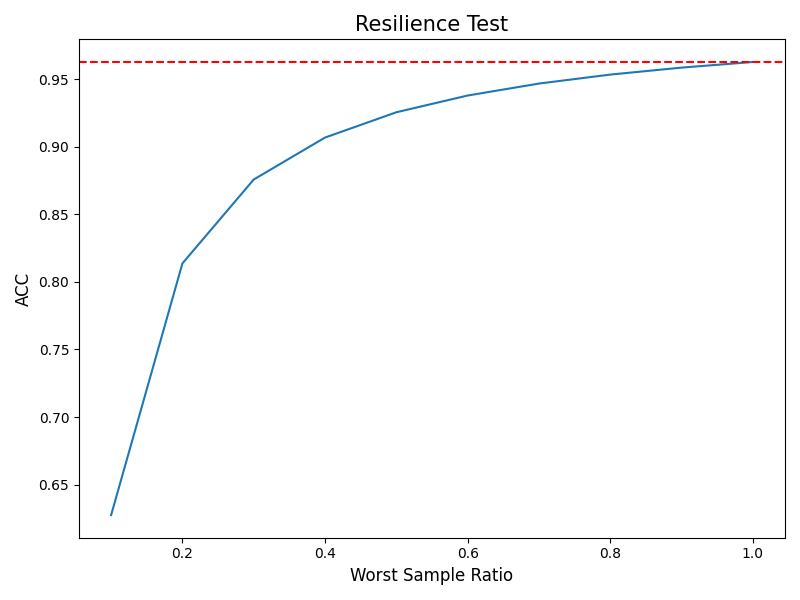

In [141]:
exp.model_diagnose(
      model='hgbt',
      show='resilience_perf',
      resilience_method='worst-sample')

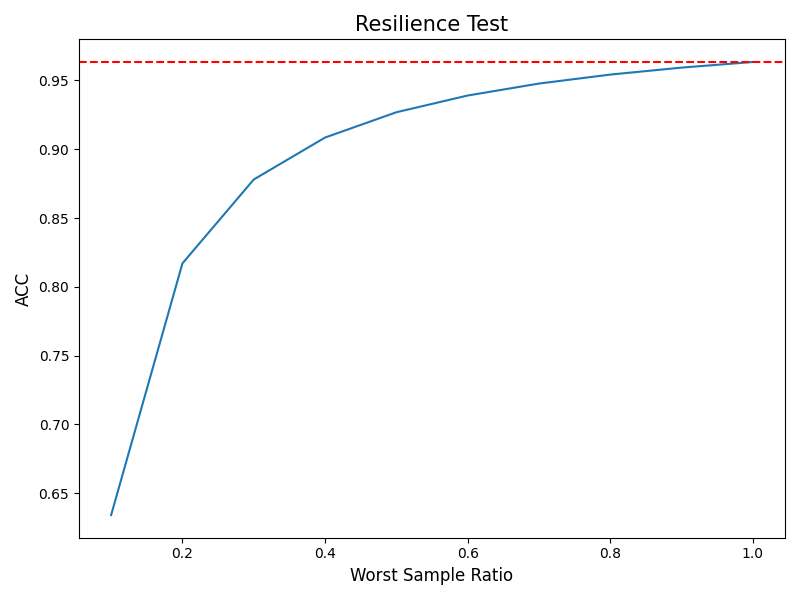

In [142]:
exp.model_diagnose(
      model='hgbt_mono',
      show='resilience_perf',
      resilience_method='worst-sample')

##### PiML resilience distance

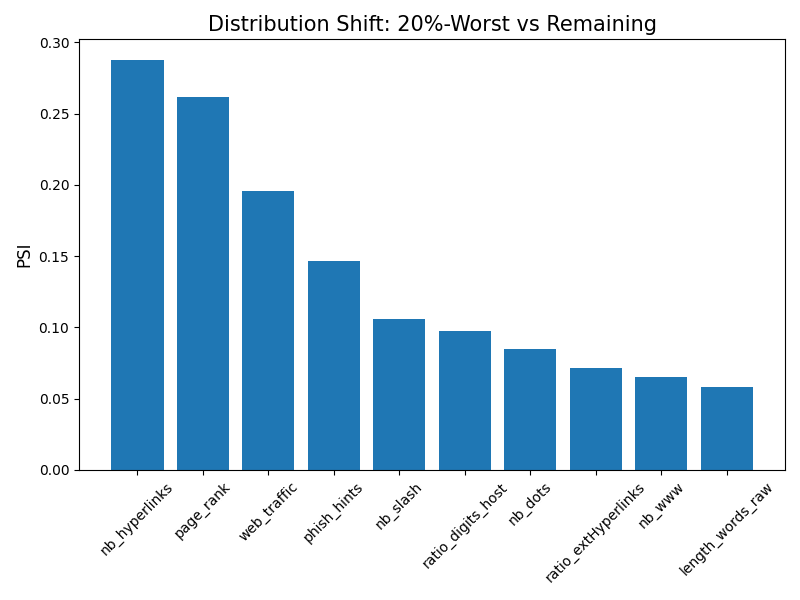

In [143]:
# Considers the effects of a distributional shift to the 20% worst observations,
# compared to
exp.model_diagnose(
      model='hgbt',
      show='resilience_distance',
      resilience_method='worst-sample',
      distance_metric = 'PSI',
      alpha=0.2)

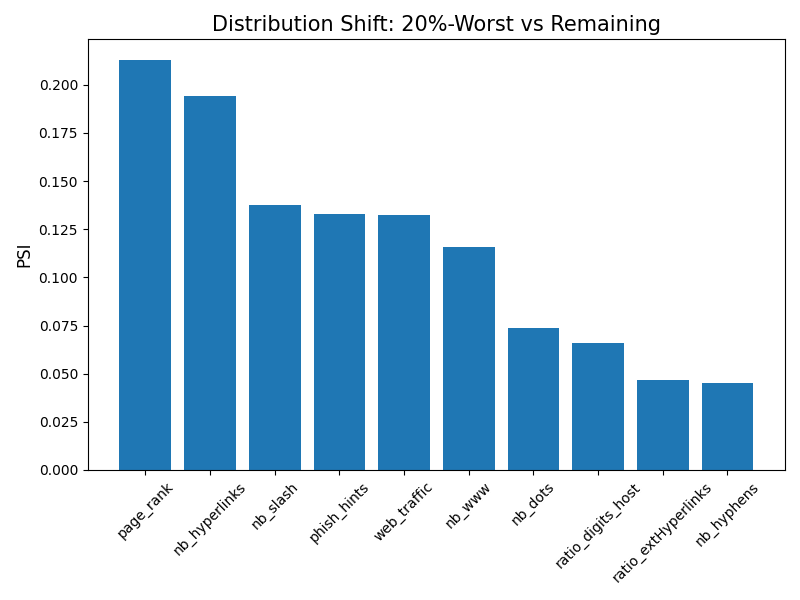

In [144]:
exp.model_diagnose(
      model='hgbt_mono',
      show='resilience_distance',
      resilience_method='worst-sample',
      distance_metric = 'PSI',
      alpha=0.2)

## Final Model Training & Evaluation



### Test Data Preparation

##### Load test data

In [163]:
#Load the final test dataset!
test_url = 'https://raw.githubusercontent.com/neal-logan/dsba6211-summer2024/main/nophishing/data/phishing-url-pirochet-test.csv'
df_test = pd.read_csv(test_url)

##### Preprocess test data

In [164]:
#Create numeric target variable column
df_test['y'] = df_test['status'].replace('legitimate', 0).replace('phishing', 1)

#Drop unnecessary columns, retaining only selected features and the target var
df_test = df_test.filter(selected_features + ['y'])

#Convert invalid values to show they are missing
import numpy as np
df_test['domain_age'] = [np.NaN if x < 0 else x for x in df_test['domain_age']]

##### Feature/target split

In [165]:
# Use both the training and validation sets for final model training to maximize performance
X_full_train = df.drop(columns=['y'])
y_full_train = df['y']

#Feature/target split - TEST
X_test = df_test.drop(columns=['y'])
y_test = df_test['y']

### Final Modeling & Model Assessment

The final model was trained the same way as the monotonicity-constrained model in almost every respect:
* used SKleran's histogram gradient-boosting classifier,
* set max_iter to 100,
* set max_depth to 8,
* set monotonic constraints on the same five features, and
* used the same random seed.

The only deviations were:
* training on the combined training and validation datasets and tested against the test set, and
* training outside a PiML experiment.

Results suggest similar outcomes to the baseline model, as expected:
* **ROC-AUC** = **0.962**
* Precision = 0.967
* Recall = 0.957

#### Further testing needed

However, further testing should be done to check for potentially overfitting (despite low risk) as well as weakspots and potential resilience issues.

##### Set up and run model pipeline - monotonically-constrained model

In [166]:
# Set up and run pipeline - gradient boosted trees
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline

pipe_gbt_prod = make_pipeline(
      HistGradientBoostingClassifier(
          max_iter=100,
          max_depth= 8,
          monotonic_cst = monotonic_contraints,
          random_state=random_seed)
)

pipe_gbt_prod.fit(X_full_train, y_full_train)

Pipeline(steps=[('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(max_depth=8,
                                                monotonic_cst=[0, -1, 0, -1, 0,
                                                               0, 0, 0, 0, 1, 0,
                                                               1, 1, 0],
                                                random_state=42))])

In [ ]:
### Experiment Setup - Final Model

### Accuracy Analysis

In [167]:
print_model_evaluation("Gradient-boosted Trees\nPerformance on Training Set",
                       pipe_gbt_prod, X_full_train, y_full_train)

print_model_evaluation("Gradient-boosted Trees\nPerformance on Test Set",
                       pipe_gbt_prod, X_test, y_test)


Gradient-boosted Trees
Performance on Training Set
[[3755   74]
 [  74 3755]]

ROC-AUC: 0.9806738051710631
Precision: 0.980673805171063
Recall: 0.980673805171063

Gradient-boosted Trees
Performance on Test Set
[[1804   63]
 [  82 1823]]

ROC-AUC: 0.9616057031435613
Precision: 0.9665959703075292
Recall: 0.9569553805774278
